<a href="https://colab.research.google.com/github/Eezzeldin/candy/blob/causalForest/candy_priceElasticity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
binary_features_cols = ["chocolate" ,
                   "fruity"    ,
                   "caramel"   ,
                   "peanutyalmondy",
                   'nougat'    ,
                   "crispedricewafer" ,
                   "hard"      ,
                   "bar"       ,
                   "pluribus"
                   ]

#'peanutyalmondy', 'caramel', 'nougat', 'bar'
#'peanutyalmondy', 'caramel', 'chocolate', 'pluribus'
#'peanutyalmondy', 'caramel', 'chocolate', 'bar'

#['fruity', 'pluribus', 'hard']


associated_features_to_chocolate = ['chocolate', 'crispedricewafer', 'fruity', 'hard', 'nougat']

non_feature_cols   = ["competitorname" , "winpercent" , "pricepercent"]

In [3]:
data = pd.read_csv ("/content/candy-data.csv")
data

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,Twizzlers,0,1,0,0,0,0,0,0,0,0.220,0.116,45.466282
81,Warheads,0,1,0,0,0,0,1,0,0,0.093,0.116,39.011898
82,Welch's Fruit Snacks,0,1,0,0,0,0,0,0,1,0.313,0.313,44.375519
83,Werther's Original Caramel,0,0,1,0,0,0,1,0,0,0.186,0.267,41.904308


In [4]:
c1 = data ["fruity"] == 1
c2 = data ["pluribus"] == 1
c = c1 & c2
data [c] [['fruity', 'pluribus', 'hard'] ]

,fruity,pluribus,hard
11,1,1,0
12,1,1,0
13,1,1,0
15,1,1,0
17,1,1,1
18,1,1,0
20,1,1,0
21,1,1,0
26,1,1,1
34,1,1,0


In [5]:
c = data ["chocolate"] == 1
data [c] [['peanutyalmondy', 'caramel', 'chocolate', 'pluribus'] ]

,peanutyalmondy,caramel,chocolate,pluribus
0,0,1,1,0
1,0,0,1,0
5,1,0,1,0
6,1,1,1,0
10,0,0,1,0
22,0,0,1,1
23,0,0,1,0
24,0,0,1,0
25,0,0,1,0
27,0,0,1,1


In [6]:
data.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   competitorname    85 non-null     object 
 1   chocolate         85 non-null     int64  
 2   fruity            85 non-null     int64  
 3   caramel           85 non-null     int64  
 4   peanutyalmondy    85 non-null     int64  
 5   nougat            85 non-null     int64  
 6   crispedricewafer  85 non-null     int64  
 7   hard              85 non-null     int64  
 8   bar               85 non-null     int64  
 9   pluribus          85 non-null     int64  
 10  sugarpercent      85 non-null     float64
 11  pricepercent      85 non-null     float64
 12  winpercent        85 non-null     float64
dtypes: float64(3), int64(9), object(1)
memory usage: 8.8+ KB


In [7]:
#!pip install econml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 24.2 MB/s eta 0:00:00


Model RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7efc23acd750>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7efc23acdf90>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7efc23ace890>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7efc23acd6f0>},
                   random_state=0, verbose=50) has a non-default cv attribute, which will be ignored


Fitting 5 folds for each of 100 candidates, totalling 500 fits


Model RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7efc23d4a770>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7efc23acd570>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7efc23d48160>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7efc23d480a0>},
                   random_state=0, verbose=50) has a non-default cv attribute, which will be ignored


Fitting 5 folds for each of 100 candidates, totalling 500 fits


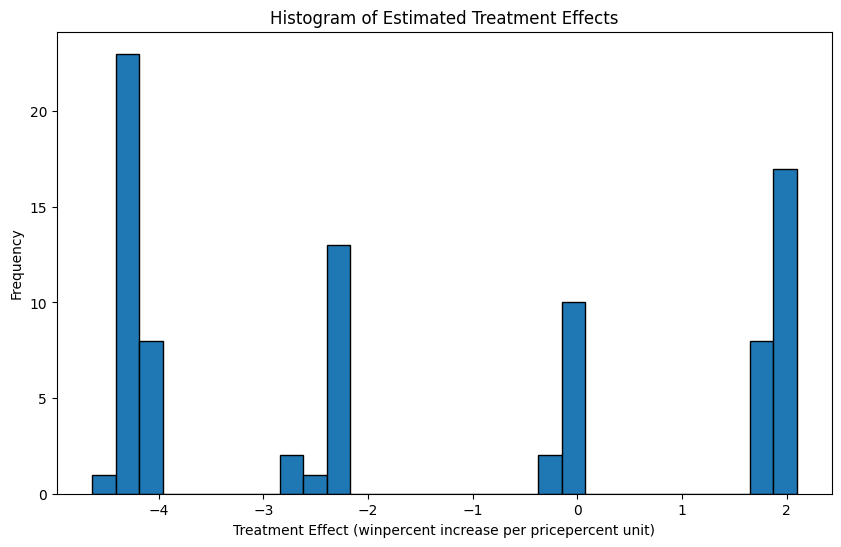

In [33]:
import pandas as pd
from econml.dml import CausalForestDML
from sklearn.ensemble import GradientBoostingRegressor
from matplotlib import pyplot as plt

# Load the dataset
candy_data = pd.read_csv("/content/candy-data.csv")

# Define features (confounders), treatment, and outcome
X = candy_data[['chocolate',  'caramel', 'peanutyalmondy' , "pluribus" , 'hard']]
W = candy_data ['sugarpercent'].values.reshape (-1,1)
T = candy_data['pricepercent']
Y = candy_data['winpercent']

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import randint

# Define the parameter distribution
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

# Instantiate the estimator
gbr = GradientBoostingRegressor(random_state=0)

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=gbr, param_distributions=param_dist,
                                   n_iter=100, cv=5, verbose=50, random_state=0, n_jobs=-1)

# Fit the RandomizedSearchCV to find the best parameters
#random_search.fit(X, Y)

# Print the best parameters and the best score
#print("Best Parameters:", random_search.best_params_)
#print("Best Score:", random_search.best_score_)


# Instantiate the Causal Forest model
causal_forest = CausalForestDML(model_y=random_search,
                                model_t=random_search,
                                cv=5,
                                random_state=123)

# Fit the model
causal_forest.fit(Y, T, X=X)

# Estimate the causal effect
te_est = causal_forest.effect(X)

# Plot the estimated treatment effect
plt.figure(figsize=(10, 6))
plt.hist(te_est, bins=30, edgecolor='k')
plt.title('Histogram of Estimated Treatment Effects')
plt.xlabel('Treatment Effect (winpercent increase per pricepercent unit)')
plt.ylabel('Frequency')
plt.show()


In [34]:
[mdl.score(X,Y) for mdls in causal_forest.models_y for mdl in mdls]

X has feature names, but GradientBoostingRegressor was fitted without feature names
X has feature names, but GradientBoostingRegressor was fitted without feature names
X has feature names, but GradientBoostingRegressor was fitted without feature names
X has feature names, but GradientBoostingRegressor was fitted without feature names
X has feature names, but GradientBoostingRegressor was fitted without feature names


[0.5384278138190965,
 0.5203360764290139,
 0.5316595044172923,
 0.5420157413098348,
 0.5353073169145712]

In [62]:
[mdl.score(X,T) for mdls in causal_forest.models_t for mdl in mdls]

X has feature names, but GradientBoostingRegressor was fitted without feature names
X has feature names, but GradientBoostingRegressor was fitted without feature names
X has feature names, but GradientBoostingRegressor was fitted without feature names
X has feature names, but GradientBoostingRegressor was fitted without feature names
X has feature names, but GradientBoostingRegressor was fitted without feature names


[0.30056482145071894,
 0.31915691175208005,
 0.24531665042104134,
 0.29197273150273095,
 0.2944668821851648]

In [35]:
[mdl for mdls in causal_forest.models_y for mdl in mdls]

[GradientBoostingRegressor(learning_rate=0.01, min_samples_leaf=3,
                           min_samples_split=9, n_estimators=380,
                           random_state=0),
 GradientBoostingRegressor(learning_rate=0.01, min_samples_leaf=3,
                           min_samples_split=9, n_estimators=380,
                           random_state=0),
 GradientBoostingRegressor(learning_rate=0.01, min_samples_leaf=3,
                           min_samples_split=9, n_estimators=380,
                           random_state=0),
 GradientBoostingRegressor(learning_rate=0.01, min_samples_leaf=3,
                           min_samples_split=9, n_estimators=380,
                           random_state=0),
 GradientBoostingRegressor(learning_rate=0.01, min_samples_leaf=3,
                           min_samples_split=9, n_estimators=380,
                           random_state=0)]

X has feature names, but GradientBoostingRegressor was fitted without feature names
X has feature names, but GradientBoostingRegressor was fitted without feature names


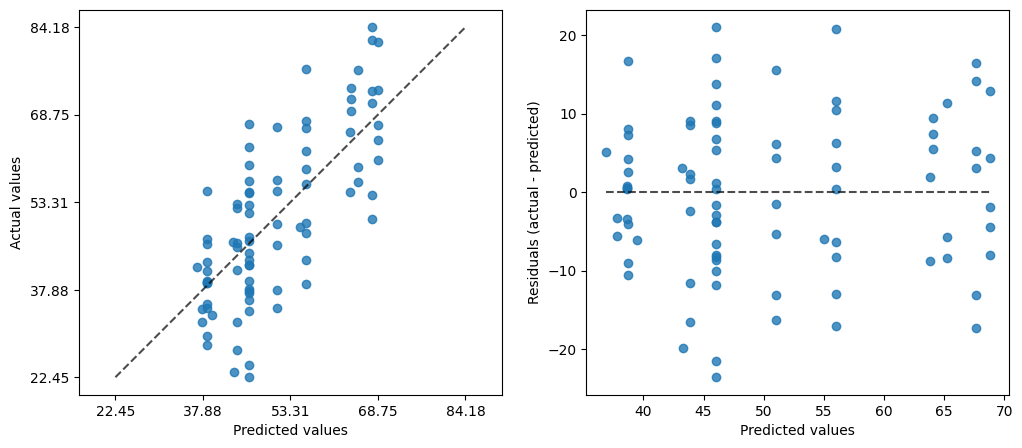

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
_ = PredictionErrorDisplay.from_estimator(
    [mdl for mdls in causal_forest.models_y for mdl in mdls] [0], X, Y, kind="actual_vs_predicted", ax=axs[0]
)
_ = PredictionErrorDisplay.from_estimator(
    [mdl for mdls in causal_forest.models_y for mdl in mdls] [0], X, Y, kind="residual_vs_predicted", ax=axs[1]
)

X has feature names, but GradientBoostingRegressor was fitted without feature names
X has feature names, but GradientBoostingRegressor was fitted without feature names


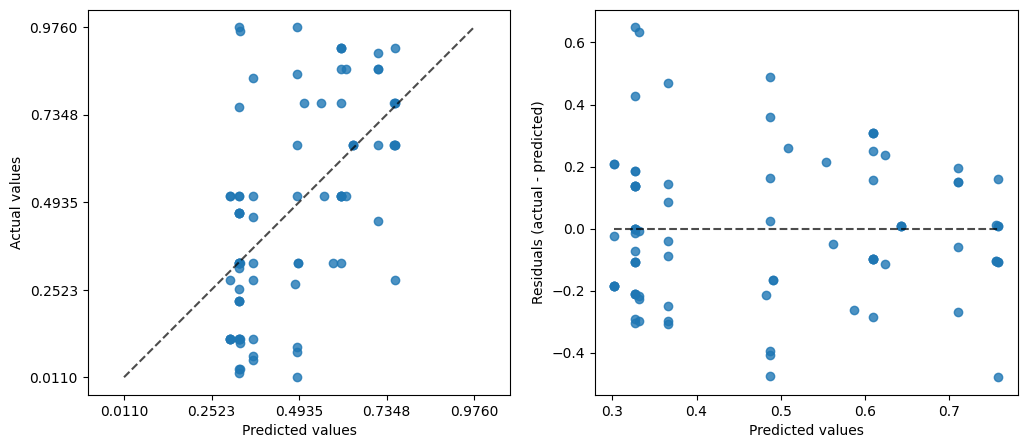

In [61]:
import matplotlib.pyplot as plt
from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
_ = PredictionErrorDisplay.from_estimator(
    [mdl for mdls in causal_forest.models_t for mdl in mdls] [1], X , T, kind="actual_vs_predicted", ax=axs[0]
)
_ = PredictionErrorDisplay.from_estimator(
    [mdl for mdls in causal_forest.models_t for mdl in mdls] [1], X , T, kind="residual_vs_predicted", ax=axs[1]
)

In [63]:
causal_forest.const_marginal_effect(X).shape

(85,)

In [64]:
causal_forest.feature_importances()

array([0.41401755, 0.01      , 0.        , 0.56555043, 0.01043202])

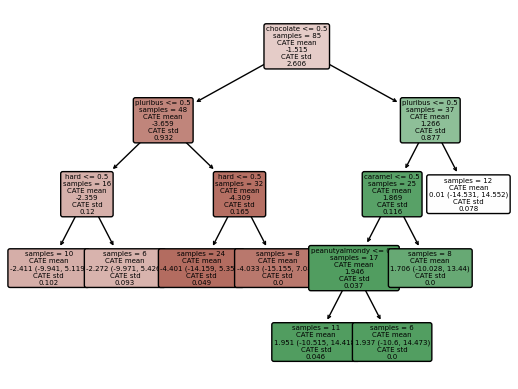

In [65]:
from econml.cate_interpreter import SingleTreeCateInterpreter
from econml.dml import LinearDML
#est = LinearDML()
#est.fit(Y, T, X=X)
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=100, min_samples_leaf=5)
# We interpret the CATE model's behavior based on the features used for heterogeneity
intrp.interpret(causal_forest, X)
# Plot the tree
intrp.plot(feature_names=X.columns, fontsize=5)